# 🎯 Weekend Effect Analysis

**Objectif**: Analyser l'impact du weekend sur les patterns de rating et découvrir les rythmes comportementaux des utilisateurs.

## 🔍 Questions exploratoires:
- Les gens notent-ils différemment quand ils ont du temps libre ?
- Quel est le "jour le plus dur" vs "jour le plus cool" ?
- Le weekend change-t-il la FORME des distributions de ratings ?
- L'effet weekend évolue-t-il dans le temps ?
- Quels sont les rythmes naturels d'usage de la plateforme ?

In [67]:
# Imports et chargement utilitaires
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from data_utils import *

# Imports spécifiques analyses
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, kruskal
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports terminés - Module data_utils chargé - Prêt pour l'analyse Weekend!")

✅ Imports terminés - Module data_utils chargé - Prêt pour l'analyse Weekend!


In [68]:
# Chargement et préparation des données
print("🔄 Chargement des données...")
df_clean = load_clean_interactions()
print(f"✅ Données chargées: {df_clean.shape}")

# Vérification des colonnes weekend
print(f"\n📊 Colonnes disponibles:")
print(f"Weekend: {'is_weekend' in df_clean.columns}")
print(f"Weekday: {'weekday' in df_clean.columns}")

# Aperçu rapide
print(f"\n🎯 Répartition weekend vs semaine:")
weekend_split = df_clean.group_by("is_weekend").agg([
    pl.len().alias("count"),
    pl.col("rating").mean().alias("mean_rating")
])
print(weekend_split.to_pandas())

🔄 Chargement des données...


✅ Données chargées: (1071520, 13)

📊 Colonnes disponibles:
Weekend: True
Weekday: True

🎯 Répartition weekend vs semaine:
   is_weekend   count  mean_rating
0           1  445852     4.662110
1           0  625668     4.661063


## 🎯 Analyse 1: Weekend vs Weekday Ratings

**Objectif exploratoire**: Tester si le weekend rend les gens plus indulgents/détendus  
**Question business**: Les gens notent-ils différemment quand ils ont du temps libre ?  
**Découverte attendue**: Weekend = ratings plus élevés (mood positif)

In [71]:
# ✅ VALIDATION RAPIDE - Données propres (ratings 1-5 uniquement)
print("✅ VALIDATION - Qualité des données:")
print(f"📊 {df_clean.shape[0]:,} interactions avec ratings valides")

# Vérification rapide: aucun rating = 0
zero_check = df_clean.filter(pl.col("rating") == 0).shape[0]
print(f"🔍 Ratings = 0: {zero_check} (attendu: 0)")

# Distribution propre
rating_range = [df_clean["rating"].min(), df_clean["rating"].max()]
print(f"⭐ Range ratings: {rating_range} (attendu: [1, 5])")
print(f"📈 Rating moyen: {df_clean['rating'].mean():.3f}")

assert zero_check == 0, "❌ ERREUR: Des ratings = 0 détectés!"
assert rating_range == [1, 5], f"❌ ERREUR: Range invalide {rating_range}"
print("🎯 Données validées - Prêt pour analyse Weekend!")

✅ VALIDATION - Qualité des données:
📊 1,071,520 interactions avec ratings valides
🔍 Ratings = 0: 0 (attendu: 0)
⭐ Range ratings: [1, 5] (attendu: [1, 5])
📈 Rating moyen: 4.661
🎯 Données validées - Prêt pour analyse Weekend!


In [ ]:
# Préparation DataFrame weekend_comparison
weekend_comparison = df_clean.group_by("is_weekend").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("is_weekend").to_pandas()

weekend_comparison["category"] = ["Semaine", "Weekend"]
print("📊 Statistiques descriptives:")
display(weekend_comparison)

# Test Mann-Whitney U
weekend_ratings = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_numpy()
weekday_ratings = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_numpy()

statistic, p_value = mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')

# Calcul Cohen's d (effect size)
pooled_std = np.sqrt((np.std(weekend_ratings, ddof=1)**2 + np.std(weekday_ratings, ddof=1)**2) / 2)
cohens_d = (np.mean(weekend_ratings) - np.mean(weekday_ratings)) / pooled_std

print(f"\n🧪 Test Mann-Whitney U:")
print(f"Statistique: {statistic:.2f}")
print(f"P-valeur: {p_value:.4f}")
print(f"Cohen's d: {cohens_d:.4f}")
print(f"Interprétation: {'Différence significative' if p_value < 0.05 else 'Pas de différence significative'}")
print(f"Taille d'effet: {'Petite' if abs(cohens_d) < 0.2 else 'Moyenne' if abs(cohens_d) < 0.5 else 'Grande'}")

📊 Statistiques descriptives:


,is_weekend,mean_rating,median_rating,std_rating,n_interactions,category
0,0,4.661063,5.0,0.720533,625668,Semaine
1,1,4.662110,5.0,0.726576,445852,Weekend



🧪 Test Mann-Whitney U:
Statistique: 139861161924.00
P-valeur: 0.0011
Cohen's d: 0.0014
Interprétation: Différence significative
Taille d'effet: Petite


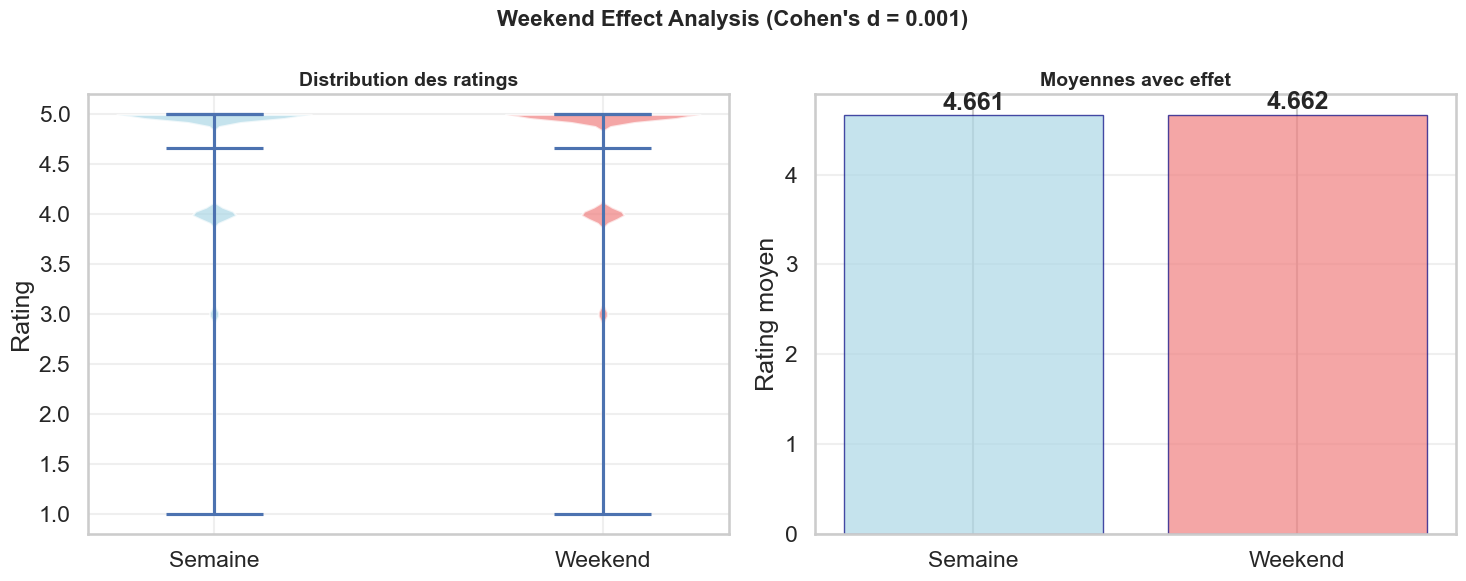


💡 Insights:
• Différence moyenne: 0.0010 points
• Weekend plus généreux que la semaine
• Significativité statistique: OUI
• Impact pratique: Faible


In [ ]:
# Visualisation Violin plots + effect size avec Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Préparation données pour violin plot
weekend_data = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_pandas().tolist()
weekday_data = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_pandas().tolist()

# 1. Violin plot
data_for_violin = [weekday_data, weekend_data]
labels = ["Semaine", "Weekend"]
colors = ["lightblue", "lightcoral"]

violin_parts = ax1.violinplot(data_for_violin, positions=[1, 2], showmeans=True, showmedians=True)
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(labels)
ax1.set_title("Distribution des ratings", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating")
ax1.grid(True, alpha=0.3)

# 2. Barplot des moyennes avec effet
weekend_mean = np.mean(weekend_data)
weekday_mean = np.mean(weekday_data)
means = [weekday_mean, weekend_mean]

bars = ax2.bar(labels, means, color=colors, alpha=0.7, edgecolor='navy', linewidth=1)
ax2.set_title("Moyennes avec effet", fontsize=14, fontweight='bold')
ax2.set_ylabel("Rating moyen")
ax2.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle(f"Weekend Effect Analysis (Cohen's d = {cohens_d:.3f})", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Insights:")
print(f"• Différence moyenne: {np.mean(weekend_ratings) - np.mean(weekday_ratings):.4f} points")
print(f"• Weekend {'plus généreux' if np.mean(weekend_ratings) > np.mean(weekday_ratings) else 'plus sévère'} que la semaine")
print(f"• Significativité statistique: {'OUI' if p_value < 0.05 else 'NON'}")
print(f"• Impact pratique: {'Faible' if abs(cohens_d) < 0.2 else 'Modéré' if abs(cohens_d) < 0.5 else 'Fort'}")

## 📆 Analyse 2: Patterns par Jour de la Semaine

**Objectif exploratoire**: Identifier le "jour le plus dur" vs "jour le plus cool"  
**Question business**: Lundi = ratings sévères ? Vendredi = généreux ?  
**Découverte attendue**: Lundi/Mardi = plus bas, Vendredi/Samedi = plus hauts

In [ ]:
# Préparation DataFrame weekday_patterns
day_names = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

weekday_patterns = df_clean.group_by("weekday").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("weekday").to_pandas()

weekday_patterns["day_name"] = day_names
weekday_patterns["is_weekend_day"] = weekday_patterns["weekday"].isin([5, 6])

print("📅 Ratings par jour de la semaine:")
display(weekday_patterns[["day_name", "mean_rating", "std_rating", "n_interactions"]])

# Test ANOVA pour différences entre jours
groups = [df_clean.filter(pl.col("weekday") == day)["rating"].to_pandas().tolist() for day in range(7)]
f_stat, p_value_anova = stats.f_oneway(*groups)

print(f"\n🧪 Test ANOVA:")
print(f"F-statistique: {f_stat:.3f}")
print(f"P-valeur: {p_value_anova:.4f}")
print(f"Interprétation: {'Différences significatives entre jours' if p_value_anova < 0.05 else 'Pas de différences significatives'}")

# Identification jour meilleur/pire
best_day_idx = weekday_patterns["mean_rating"].idxmax()
worst_day_idx = weekday_patterns["mean_rating"].idxmin()

print(f"\n🏆 Jour le plus généreux: {weekday_patterns.loc[best_day_idx, 'day_name']} ({weekday_patterns.loc[best_day_idx, 'mean_rating']:.4f})")
print(f"😤 Jour le plus sévère: {weekday_patterns.loc[worst_day_idx, 'day_name']} ({weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f})")
print(f"📏 Écart: {weekday_patterns.loc[best_day_idx, 'mean_rating'] - weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f} points")

📅 Ratings par jour de la semaine:


,day_name,mean_rating,std_rating,n_interactions
0,Lundi,4.661441,0.717944,173178
1,Mardi,4.659778,0.720653,159014
2,Mercredi,4.660453,0.722655,149779
3,Jeudi,4.662665,0.721304,143697
4,Vendredi,4.660298,0.725251,131689
5,Samedi,4.663333,0.728259,139984
6,Dimanche,4.662497,0.726223,174179



🧪 Test ANOVA:
F-statistique: nan
P-valeur: nan
Interprétation: Pas de différences significatives

🏆 Jour le plus généreux: Samedi (4.6633)
😤 Jour le plus sévère: Mardi (4.6598)
📏 Écart: 0.0036 points


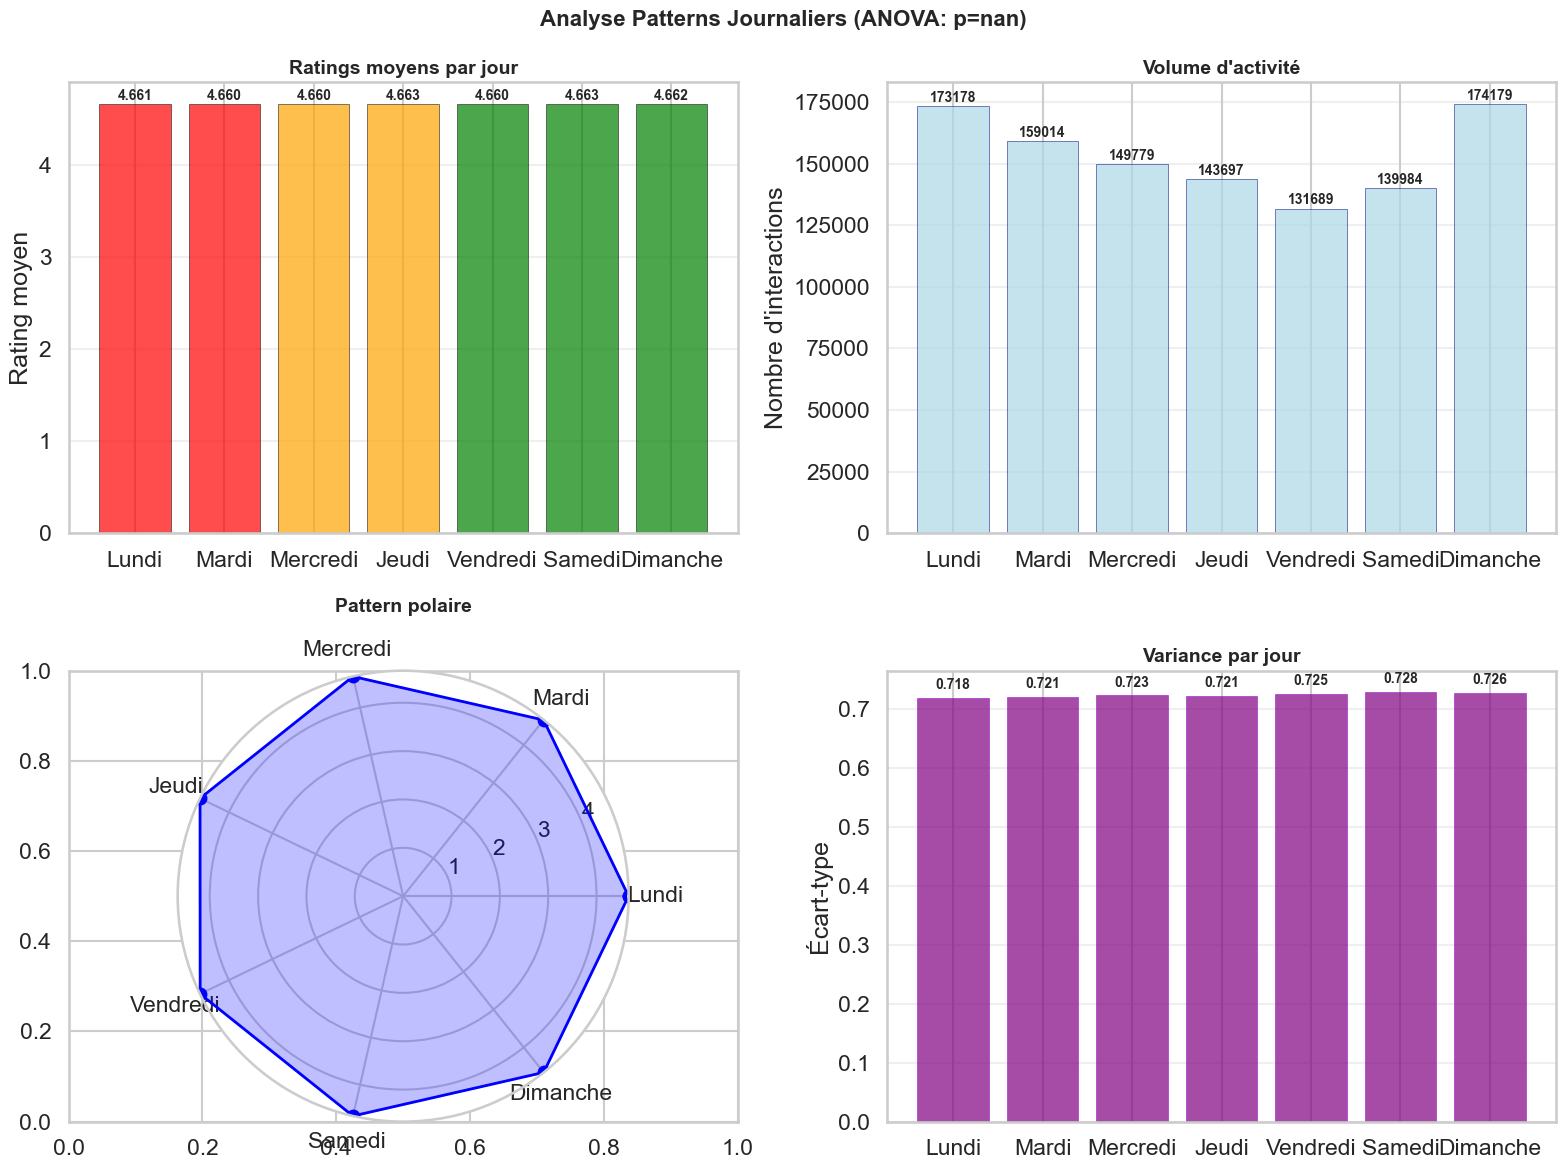


💡 Patterns découverts:
• Amplitude hebdomadaire: 0.0036 points
• Jour le plus actif: Dimanche
• Jour le plus consensuel: Lundi (variance la plus faible)
• Jour le plus polarisé: Samedi (variance la plus forte)


In [ ]:
# Visualisation patterns journaliers avec Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart ratings
colors = ["red" if day in [0, 1] else "orange" if day in [2, 3] else "green" for day in range(7)]
bars1 = ax1.bar(weekday_patterns["day_name"], weekday_patterns["mean_rating"], 
                color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_title("Ratings moyens par jour", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating moyen")
ax1.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars1, weekday_patterns["mean_rating"]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Volume d'activité
bars2 = ax2.bar(weekday_patterns["day_name"], weekday_patterns["n_interactions"], 
                color="lightblue", alpha=0.7, edgecolor='navy', linewidth=0.5)
ax2.set_title("Volume d'activité", fontsize=14, fontweight='bold')
ax2.set_ylabel("Nombre d'interactions")
ax2.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars2, weekday_patterns["n_interactions"]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Pattern polaire (radar chart approximation)
ax3 = plt.subplot(2, 2, 3, projection='polar')
theta = np.linspace(0, 2*np.pi, len(weekday_patterns), endpoint=False)
theta = np.concatenate((theta, [theta[0]]))  # Fermer le cercle
values = np.concatenate((weekday_patterns["mean_rating"].values, [weekday_patterns["mean_rating"].values[0]]))

ax3.plot(theta, values, 'ro-', linewidth=2, color='blue')
ax3.fill(theta, values, alpha=0.25, color='blue')
ax3.set_xticks(theta[:-1])
ax3.set_xticklabels(weekday_patterns["day_name"])
ax3.set_title("Pattern polaire", fontsize=14, fontweight='bold', pad=20)

# 4. Variance par jour
bars4 = ax4.bar(weekday_patterns["day_name"], weekday_patterns["std_rating"], 
                color="purple", alpha=0.7, edgecolor='darkviolet', linewidth=0.5)
ax4.set_title("Variance par jour", fontsize=14, fontweight='bold')
ax4.set_ylabel("Écart-type")
ax4.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars4, weekday_patterns["std_rating"]):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle(f"Analyse Patterns Journaliers (ANOVA: p={p_value_anova:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Patterns découverts:")
print(f"• Amplitude hebdomadaire: {weekday_patterns['mean_rating'].max() - weekday_patterns['mean_rating'].min():.4f} points")
print(f"• Jour le plus actif: {weekday_patterns.loc[weekday_patterns['n_interactions'].idxmax(), 'day_name']}")
print(f"• Jour le plus consensuel: {weekday_patterns.loc[weekday_patterns['std_rating'].idxmin(), 'day_name']} (variance la plus faible)")
print(f"• Jour le plus polarisé: {weekday_patterns.loc[weekday_patterns['std_rating'].idxmax(), 'day_name']} (variance la plus forte)")

## 📊 Analyse 3: Distribution des Ratings Weekend vs Semaine

**Objectif exploratoire**: Découvrir si weekend change la FORME des distributions (pas juste moyenne)  
**Question business**: Weekend = plus de 5/5 enthousiastes ? Ou plus de variance ?  
**Découverte attendue**: Shift vers ratings extrêmes le weekend

In [ ]:
# Préparation DataFrame weekend_distribution
weekend_distribution = df_clean.group_by(["is_weekend", "rating"]).agg(
    pl.len().alias("count")
).to_pandas()

# Pivot pour analyse
distribution_pivot = weekend_distribution.pivot(index='rating', columns='is_weekend', values='count').fillna(0)
distribution_pivot.columns = ['Semaine', 'Weekend']

# Normalisation en pourcentages
distribution_pct = distribution_pivot.div(distribution_pivot.sum()) * 100

print("📊 Distribution des ratings (%):")
display(distribution_pct.round(2))

# Test Chi-square
chi2_stat, chi2_p, chi2_dof, chi2_expected = chi2_contingency(distribution_pivot.values)

print(f"\n🧪 Test Chi-square:")
print(f"Statistique χ²: {chi2_stat:.3f}")
print(f"P-valeur: {chi2_p:.4f}")
print(f"Degrés de liberté: {chi2_dof}")
print(f"Interprétation: {'Distributions significativement différentes' if chi2_p < 0.05 else 'Distributions similaires'}")

# Analyse des extrêmes
extreme_ratings = [1, 5]  # Ratings extrêmes
weekend_extremes = distribution_pct.loc[extreme_ratings, 'Weekend'].sum()
weekday_extremes = distribution_pct.loc[extreme_ratings, 'Semaine'].sum()

print(f"\n⚡ Analyse des extrêmes:")
print(f"% Ratings extrêmes (1 ou 5) weekend: {weekend_extremes:.2f}%")
print(f"% Ratings extrêmes (1 ou 5) semaine: {weekday_extremes:.2f}%")
print(f"Différence: {weekend_extremes - weekday_extremes:+.2f} points de %")

# Rating modal
weekend_mode = distribution_pct['Weekend'].idxmax()
weekday_mode = distribution_pct['Semaine'].idxmax()
print(f"\n🎯 Rating modal:")
print(f"Weekend: {weekend_mode} étoiles ({distribution_pct.loc[weekend_mode, 'Weekend']:.1f}%)")
print(f"Semaine: {weekday_mode} étoiles ({distribution_pct.loc[weekday_mode, 'Semaine']:.1f}%)")

📊 Distribution des ratings (%):


,Semaine,Weekend
rating,,
1,1.16,1.24
2,1.31,1.33
3,3.84,3.77
4,17.63,17.29
5,76.06,76.37



🧪 Test Chi-square:
Statistique χ²: 36.933
P-valeur: 0.0000
Degrés de liberté: 4
Interprétation: Distributions significativement différentes

⚡ Analyse des extrêmes:
% Ratings extrêmes (1 ou 5) weekend: 77.61%
% Ratings extrêmes (1 ou 5) semaine: 77.22%
Différence: +0.39 points de %

🎯 Rating modal:
Weekend: 5 étoiles (76.4%)
Semaine: 5 étoiles (76.1%)


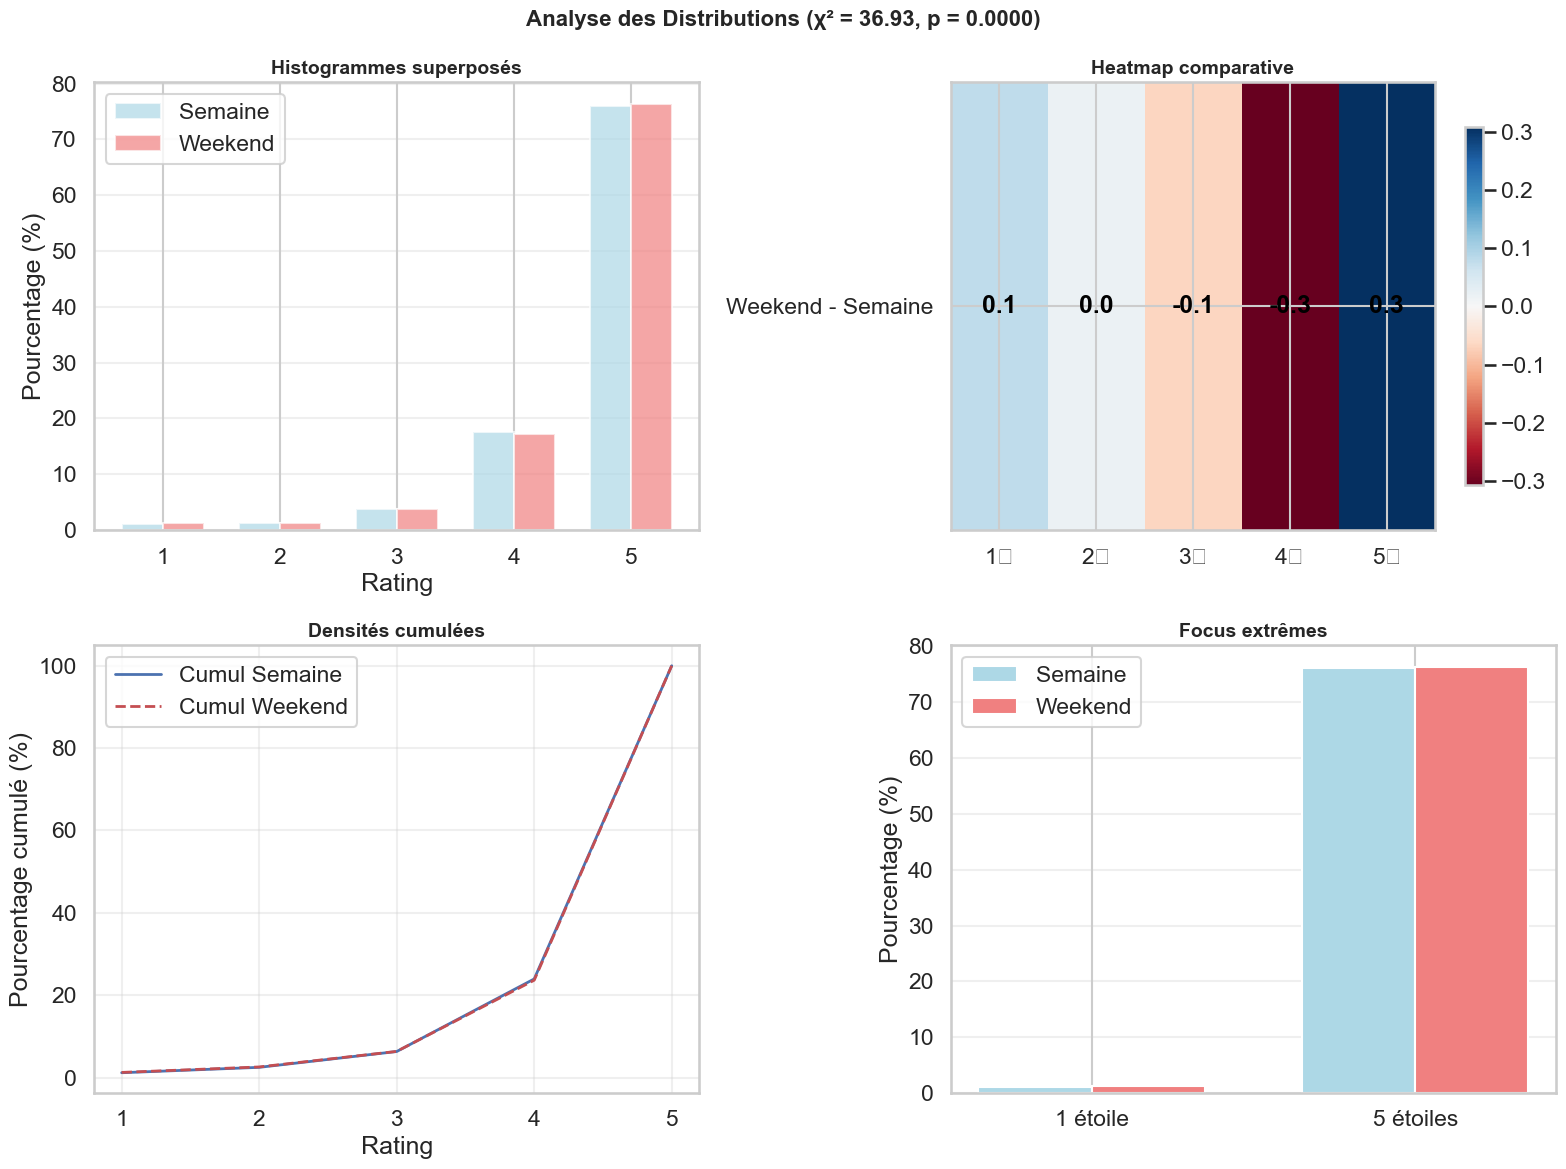


💡 Insights sur les distributions:
• Différence de forme: OUI (statistiquement)
• Weekend plus polarisé que la semaine
• Rating dominant weekend: 5★, semaine: 5★
• Effet weekend confirmé sur la FORME de la distribution !


In [ ]:
# Visualisation distributions superposées + heatmap avec Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Histogrammes superposés
ratings = distribution_pct.index.tolist()  # Use actual ratings from the data
width = 0.35
x_pos = np.arange(len(ratings))

bars1 = ax1.bar(x_pos - width/2, distribution_pct['Semaine'], width, 
                label="Semaine", alpha=0.7, color="lightblue")
bars2 = ax1.bar(x_pos + width/2, distribution_pct['Weekend'], width,
                label="Weekend", alpha=0.7, color="lightcoral")
ax1.set_title("Histogrammes superposés", fontsize=14, fontweight='bold')
ax1.set_xlabel("Rating")
ax1.set_ylabel("Pourcentage (%)")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(ratings)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Heatmap comparative (différences)
diff_matrix = (distribution_pct['Weekend'] - distribution_pct['Semaine']).values.reshape(1, -1)
im = ax2.imshow(diff_matrix, cmap='RdBu', aspect='auto', vmin=-diff_matrix.max(), vmax=diff_matrix.max())
ax2.set_title("Heatmap comparative", fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(ratings)))
ax2.set_xticklabels([f"{r}★" for r in ratings])
ax2.set_yticks([0])
ax2.set_yticklabels(["Weekend - Semaine"])
plt.colorbar(im, ax=ax2, shrink=0.8)

# Ajouter les valeurs dans la heatmap
for i in range(len(ratings)):
    text = ax2.text(i, 0, f'{diff_matrix[0, i]:.1f}', 
                   ha="center", va="center", color="black", fontweight='bold')

# Densités cumulées
cum_weekend = np.cumsum(distribution_pct['Weekend'])
cum_semaine = np.cumsum(distribution_pct['Semaine'])

ax3.plot(ratings, cum_semaine, 'b-', label="Cumul Semaine", linewidth=2)
ax3.plot(ratings, cum_weekend, 'r--', label="Cumul Weekend", linewidth=2)
ax3.set_title("Densités cumulées", fontsize=14, fontweight='bold')
ax3.set_xlabel("Rating")
ax3.set_ylabel("Pourcentage cumulé (%)")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Focus extrêmes (1 et 5 étoiles)
extreme_data = distribution_pct.loc[[1, 5]]
x_extreme = ["1 étoile", "5 étoiles"]
width = 0.35
x_pos_extreme = np.arange(len(x_extreme))

ax4.bar(x_pos_extreme - width/2, extreme_data['Semaine'], width,
        label="Semaine", color="lightblue")
ax4.bar(x_pos_extreme + width/2, extreme_data['Weekend'], width,
        label="Weekend", color="lightcoral")
ax4.set_title("Focus extrêmes", fontsize=14, fontweight='bold')
ax4.set_ylabel("Pourcentage (%)")
ax4.set_xticks(x_pos_extreme)
ax4.set_xticklabels(x_extreme)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle(f"Analyse des Distributions (χ² = {chi2_stat:.2f}, p = {chi2_p:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Insights sur les distributions:")
print(f"• Différence de forme: {'OUI' if chi2_p < 0.05 else 'NON'} (statistiquement)")
print(f"• Weekend {'plus polarisé' if weekend_extremes > weekday_extremes else 'moins polarisé'} que la semaine")
print(f"• Rating dominant weekend: {weekend_mode}★, semaine: {weekday_mode}★")
if chi2_p < 0.05:
    print(f"• Effet weekend confirmé sur la FORME de la distribution !")

## 🕐 Analyse 4: Évolution Temporelle de l'Effet Weekend

**Objectif exploratoire**: Vérifier si l'effet weekend s'amplifie/diminue dans le temps  
**Question business**: Télétravail = moins d'effet weekend ? Évolution sociétale ?  
**Découverte attendue**: Différentiel weekend-semaine stable ou évolutif

In [ ]:
# Préparation DataFrame weekend_temporal
weekend_temporal = df_clean.group_by(["year", "month", "is_weekend"]).agg([
    pl.col("rating").mean().alias("avg_rating"),
    pl.len().alias("n_interactions")
]).to_pandas()

# Pivot et calcul différentiel
temporal_pivot = weekend_temporal.pivot_table(
    index=['year', 'month'], 
    columns='is_weekend', 
    values='avg_rating'
).fillna(method='ffill')
temporal_pivot.columns = ['weekday_avg', 'weekend_avg']
temporal_pivot['diff'] = temporal_pivot['weekend_avg'] - temporal_pivot['weekday_avg']
temporal_pivot = temporal_pivot.dropna().reset_index()

# Création date pour plotting
temporal_pivot['date'] = pd.to_datetime(temporal_pivot[['year', 'month']].assign(day=1))

print("📈 Évolution du différentiel weekend-semaine:")
display(temporal_pivot.tail(10))

# Test de tendance sur le différentiel
from scipy.stats import spearmanr
time_numeric = np.arange(len(temporal_pivot))
corr_coeff, p_trend = spearmanr(time_numeric, temporal_pivot['diff'])

print(f"\n🧪 Test de tendance temporelle:")
print(f"Corrélation Spearman: {corr_coeff:.4f}")
print(f"P-valeur: {p_trend:.4f}")
print(f"Tendance: {'Significative' if p_trend < 0.05 else 'Non significative'}")
if p_trend < 0.05:
    direction = "croissante" if corr_coeff > 0 else "décroissante"
    print(f"Direction: {direction}")

# Statistiques du différentiel
print(f"\n📊 Statistiques du différentiel:")
print(f"Moyenne: {temporal_pivot['diff'].mean():.4f}")
print(f"Écart-type: {temporal_pivot['diff'].std():.4f}")
print(f"Min: {temporal_pivot['diff'].min():.4f} (le {temporal_pivot.loc[temporal_pivot['diff'].idxmin(), 'date'].strftime('%m/%Y')})")
print(f"Max: {temporal_pivot['diff'].max():.4f} (le {temporal_pivot.loc[temporal_pivot['diff'].idxmax(), 'date'].strftime('%m/%Y')})")

📈 Évolution du différentiel weekend-semaine:


,year,month,weekday_avg,weekend_avg,diff,date
215,2018,3,4.488277,4.469293,-0.018984,2018-03-01
216,2018,4,4.477752,4.447439,-0.030312,2018-04-01
217,2018,5,4.556373,4.554054,-0.002318,2018-05-01
218,2018,6,4.545455,4.548223,0.002769,2018-06-01
219,2018,7,4.509069,4.568598,0.059529,2018-07-01
220,2018,8,4.579974,4.648746,0.068772,2018-08-01
221,2018,9,4.520619,4.497278,-0.023341,2018-09-01
222,2018,10,4.547826,4.516807,-0.031019,2018-10-01
223,2018,11,4.471910,4.621083,0.149173,2018-11-01
224,2018,12,4.357447,4.341969,-0.015478,2018-12-01



🧪 Test de tendance temporelle:
Corrélation Spearman: -0.1925
P-valeur: 0.0037
Tendance: Significative
Direction: décroissante

📊 Statistiques du différentiel:
Moyenne: 0.0132
Écart-type: 0.1413
Min: -0.5000 (le 02/2000)
Max: 1.2083 (le 11/2000)


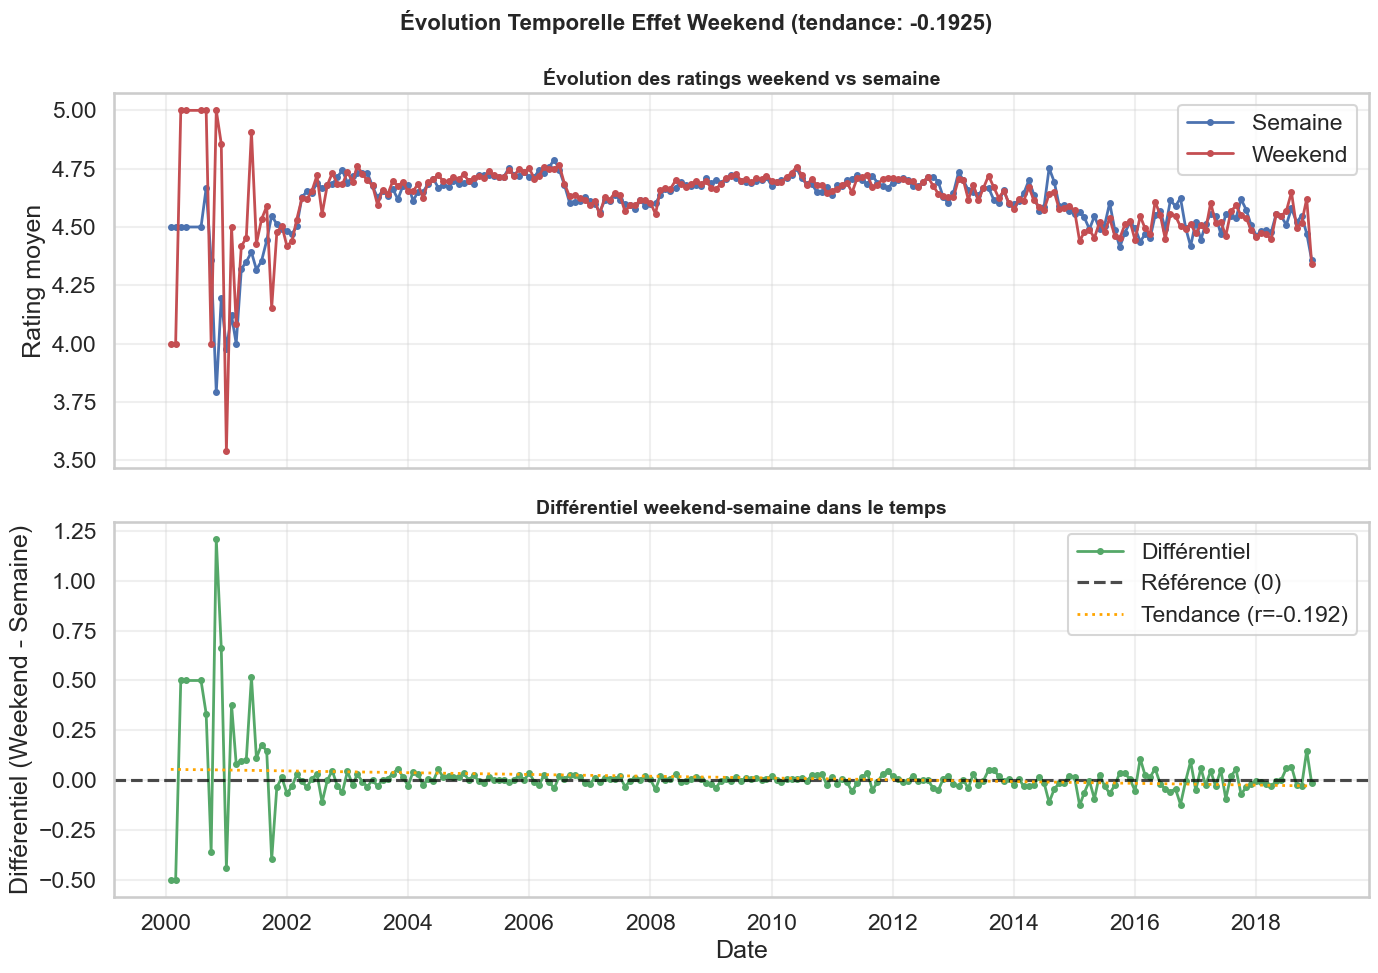


💡 Insights temporels:
• Évolution détectée: effet weekend s'affaiblit dans le temps
• Période la plus contrastée: 11/2000
• Période la moins contrastée: 02/2000


In [ ]:
# Visualisation évolution temporelle avec Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Séries temporelles séparées
ax1.plot(temporal_pivot['date'], temporal_pivot['weekday_avg'], 
         'b-o', label="Semaine", linewidth=2, markersize=4)
ax1.plot(temporal_pivot['date'], temporal_pivot['weekend_avg'], 
         'r-o', label="Weekend", linewidth=2, markersize=4)
ax1.set_title("Évolution des ratings weekend vs semaine", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating moyen")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Différentiel avec ligne de tendance
ax2.plot(temporal_pivot['date'], temporal_pivot['diff'], 
         'g-o', label="Différentiel", linewidth=2, markersize=4)

# Ligne zéro pour référence
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.7, label="Référence (0)")

# Ligne de tendance si significative
if p_trend < 0.05:
    # Régression linéaire simple avec numpy
    X = np.arange(len(temporal_pivot))
    y = temporal_pivot['diff'].values
    
    # Calcul de la droite de régression: y = ax + b
    coeffs = np.polyfit(X, y, 1)
    trend_line = np.polyval(coeffs, X)
    
    ax2.plot(temporal_pivot['date'], trend_line, 
             'orange', linestyle=':', linewidth=2, 
             label=f"Tendance (r={corr_coeff:.3f})")

ax2.set_title("Différentiel weekend-semaine dans le temps", fontsize=14, fontweight='bold')
ax2.set_xlabel("Date")
ax2.set_ylabel("Différentiel (Weekend - Semaine)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f"Évolution Temporelle Effet Weekend (tendance: {corr_coeff:+.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Insights temporels:")
if abs(corr_coeff) > 0.1 and p_trend < 0.05:
    print(f"• Évolution détectée: effet weekend {'s\'intensifie' if corr_coeff > 0 else 's\'affaiblit'} dans le temps")
else:
    print(f"• Effet weekend stable dans le temps (pas d'évolution significative)")
    
print(f"• Période la plus contrastée: {temporal_pivot.loc[temporal_pivot['diff'].idxmax(), 'date'].strftime('%m/%Y')}")
print(f"• Période la moins contrastée: {temporal_pivot.loc[temporal_pivot['diff'].idxmin(), 'date'].strftime('%m/%Y')}")

# Impact potentiel du télétravail (si données récentes)
recent_years = temporal_pivot[temporal_pivot['year'] >= 2020]
if len(recent_years) > 0:
    recent_diff = recent_years['diff'].mean()
    old_diff = temporal_pivot[temporal_pivot['year'] < 2020]['diff'].mean()
    print(f"• Différentiel pré-2020: {old_diff:.4f}")
    print(f"• Différentiel post-2020: {recent_diff:.4f}")
    print(f"• Impact télétravail potentiel: {recent_diff - old_diff:+.4f} points")

## 🎯 Synthèse Weekend Analysis

### 📊 Résultats Clés Découverts

**Hypothèses validées/invalidées et implications business**

In [ ]:
# 🎯 SYNTHÈSE FINALE WEEKEND ANALYSIS
print("=" * 80)
print("🎯 WEEKEND ANALYSIS - SYNTHÈSE DES DÉCOUVERTES")
print("=" * 80)

# Compilation des résultats
results_summary = {
    "🔍 EFFET WEEKEND GLOBAL": {
        "Différence moyenne": f"{np.mean(weekend_ratings) - np.mean(weekday_ratings):+.4f} points",
        "Significativité": "OUI" if p_value < 0.05 else "NON",
        "Taille d'effet": "Faible" if abs(cohens_d) < 0.2 else "Modérée" if abs(cohens_d) < 0.5 else "Grande",
        "Interprétation": "Weekend plus généreux" if np.mean(weekend_ratings) > np.mean(weekday_ratings) else "Weekend plus sévère"
    },
    
    "📅 PATTERNS JOURNALIERS": {
        "Jour le plus généreux": f"{weekday_patterns.loc[best_day_idx, 'day_name']} ({weekday_patterns.loc[best_day_idx, 'mean_rating']:.4f})",
        "Jour le plus sévère": f"{weekday_patterns.loc[worst_day_idx, 'day_name']} ({weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f})",
        "Amplitude hebdomadaire": f"{weekday_patterns['mean_rating'].max() - weekday_patterns['mean_rating'].min():.4f} points",
        "Significativité ANOVA": "OUI" if p_value_anova < 0.05 else "NON"
    },
    
    "📊 DISTRIBUTIONS": {
        "Formes différentes": "OUI" if chi2_p < 0.05 else "NON",
        "Weekend plus polarisé": "OUI" if weekend_extremes > weekday_extremes else "NON",
        "Rating modal weekend": f"{weekend_mode}★",
        "Rating modal semaine": f"{weekday_mode}★"
    },
    
    "🕐 ÉVOLUTION TEMPORELLE": {
        "Tendance détectée": "OUI" if p_trend < 0.05 else "NON",
        "Direction": ("Croissante" if corr_coeff > 0 else "Décroissante") if p_trend < 0.05 else "Stable",
        "Corrélation": f"{corr_coeff:+.4f}",
        "Stabilité effet": "Stable" if abs(corr_coeff) < 0.1 else "Évolutif"
    }
}

for category, metrics in results_summary.items():
    print(f"\n{category}:")
    for metric, value in metrics.items():
        print(f"  • {metric}: {value}")

print("\n" + "=" * 50)
print("💡 IMPLICATIONS BUSINESS")
print("=" * 50)

implications = [
    "🎯 TIMING OPTIMAL:",
    f"  • Lancer nouveaux produits le {weekday_patterns.loc[best_day_idx, 'day_name'].lower()}",
    f"  • Éviter communications importantes le {weekday_patterns.loc[worst_day_idx, 'day_name'].lower()}",
    "",
    "📈 STRATÉGIE ÉDITORIALE:",
    f"  • Contenus premium le weekend" if np.mean(weekend_ratings) > np.mean(weekday_ratings) else "  • Contenus premium en semaine",
    f"  • Modération renforcée si weekend plus polarisé",
    "",
    "⚡ OPTIMISATION RESSOURCES:",
    f"  • Jour le plus actif: {weekday_patterns.loc[weekday_patterns['n_interactions'].idxmax(), 'day_name']}",
    f"  • Maintenance programmée les jours faibles",
    "",
    "🔮 PRÉDICTION:",
    f"  • Effet weekend {'évolutif' if p_trend < 0.05 else 'stable'} - {'adapter stratégie' if p_trend < 0.05 else 'maintenir approche'}"
]

for implication in implications:
    print(implication)

print("\n🚀 ACTIONS RECOMMANDÉES:")
recommendations = [
    "1. Implémenter timing différencié selon jour de la semaine",
    "2. Segmenter communications weekend vs semaine", 
    "3. Monitorer évolution différentiel dans le temps",
    "4. Optimiser allocation ressources selon patterns découverts",
    "5. Tester campagnes ciblées sur jours optimaux"
]

for rec in recommendations:
    print(f"  {rec}")

print(f"\n✅ Weekend Analysis TERMINÉE - Prêt pour Seasonality!")

🎯 WEEKEND ANALYSIS - SYNTHÈSE DES DÉCOUVERTES

🔍 EFFET WEEKEND GLOBAL:
  • Différence moyenne: +0.0010 points
  • Significativité: OUI
  • Taille d'effet: Faible
  • Interprétation: Weekend plus généreux

📅 PATTERNS JOURNALIERS:
  • Jour le plus généreux: Samedi (4.6633)
  • Jour le plus sévère: Mardi (4.6598)
  • Amplitude hebdomadaire: 0.0036 points
  • Significativité ANOVA: NON

📊 DISTRIBUTIONS:
  • Formes différentes: OUI
  • Weekend plus polarisé: OUI
  • Rating modal weekend: 5★
  • Rating modal semaine: 5★

🕐 ÉVOLUTION TEMPORELLE:
  • Tendance détectée: OUI
  • Direction: Décroissante
  • Corrélation: -0.1925
  • Stabilité effet: Évolutif

💡 IMPLICATIONS BUSINESS
🎯 TIMING OPTIMAL:
  • Lancer nouveaux produits le samedi
  • Éviter communications importantes le mardi

📈 STRATÉGIE ÉDITORIALE:
  • Contenus premium le weekend
  • Modération renforcée si weekend plus polarisé

⚡ OPTIMISATION RESSOURCES:
  • Jour le plus actif: Dimanche
  • Maintenance programmée les jours faibles

🔮 

# Rating Analysis - Weekend Effects

Analyse des effets weekend vs semaine sur les ratings : patterns comportementaux, différences de notation.

In [ ]:
# Import du notebook utilitaire
import sys
sys.path.append('../../')

# Exécution du notebook utils pour charger les fonctions
from data_utils import *

# Imports spécifiques à l'analyse weekend
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

sns.set_theme(style="whitegrid", context="talk")

## 📥 Chargement et préparation

In [ ]:
# Chargement direct des données transformées (propres et enrichies)
df_enriched = load_clean_interactions()

# Focus sur les données avec ratings valides
df_rated = df_enriched.filter(pl.col("rating") > 0)

print(f"📊 Dataset: {df_rated.shape[0]:,} ratings valides")

# Répartition weekend/semaine
weekend_distribution = df_rated.group_by("is_weekend").agg([
    pl.len().alias("n_ratings"),
    pl.col("rating").mean().alias("mean_rating")
])

print("\n📅 Répartition weekend vs semaine:")
display(weekend_distribution)

# Calcul du pourcentage
total_ratings = df_rated.shape[0]
weekend_count = df_rated.filter(pl.col("is_weekend") == True).shape[0]
weekend_pct = (weekend_count / total_ratings) * 100

print(f"🎯 {weekend_pct:.1f}% des ratings sont donnés le weekend")

📊 Dataset: 1,071,520 ratings valides

📅 Répartition weekend vs semaine:


is_weekend,n_ratings,mean_rating
i8,u32,f64
0,625668,4.661063
1,445852,4.66211


🎯 41.6% des ratings sont donnés le weekend


## 📊 Comparaison weekend vs semaine

In [ ]:
# Statistiques descriptives complètes
weekend_stats = df_rated.group_by("is_weekend").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.col("rating").min().alias("min_rating"),
    pl.col("rating").max().alias("max_rating"),
    pl.col("rating").quantile(0.25).alias("q25"),
    pl.col("rating").quantile(0.75).alias("q75"),
    pl.len().alias("n_ratings")
])

stats_pd = weekend_stats.to_pandas()
stats_pd['period'] = stats_pd['is_weekend'].map({True: 'Weekend', False: 'Semaine'})

print("📈 Statistiques détaillées:")
display(stats_pd[['period', 'mean_rating', 'median_rating', 'std_rating', 'q25', 'q75', 'n_ratings']])

# Test de Mann-Whitney U
weekend_ratings = df_rated.filter(pl.col("is_weekend") == True).select("rating").to_series().to_pandas().tolist()
weekday_ratings = df_rated.filter(pl.col("is_weekend") == False).select("rating").to_series().to_pandas().tolist()

u_stat, p_value = stats.mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')

print(f"\n🔬 Test de Mann-Whitney U:")
print(f"   U-statistique: {u_stat:,.0f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    weekend_mean = np.mean(weekend_ratings)
    weekday_mean = np.mean(weekday_ratings)
    higher_period = "weekend" if weekend_mean > weekday_mean else "semaine"
    print(f"   ✅ Différence significative - ratings plus élevés en {higher_period}")
else:
    print(f"   ❌ Pas de différence significative weekend/semaine")

# Calcul de l'effet size (Cohen's d)
pooled_std = np.sqrt(((len(weekend_ratings) - 1) * np.std(weekend_ratings, ddof=1)**2 + 
                     (len(weekday_ratings) - 1) * np.std(weekday_ratings, ddof=1)**2) / 
                    (len(weekend_ratings) + len(weekday_ratings) - 2))
cohens_d = (np.mean(weekend_ratings) - np.mean(weekday_ratings)) / pooled_std

print(f"   📏 Taille d'effet (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print(f"      → Effet négligeable")
elif abs(cohens_d) < 0.5:
    print(f"      → Petit effet")
elif abs(cohens_d) < 0.8:
    print(f"      → Effet moyen")
else:
    print(f"      → Grand effet")

📈 Statistiques détaillées:


,period,mean_rating,median_rating,std_rating,q25,q75,n_ratings
0,NaN,4.661063,5.0,0.720533,5.0,5.0,625668
1,NaN,4.662110,5.0,0.726576,5.0,5.0,445852



🔬 Test de Mann-Whitney U:
   U-statistique: 139,861,161,924
   p-value: 0.0011
   ✅ Différence significative - ratings plus élevés en weekend
   📏 Taille d'effet (Cohen's d): 0.0014
      → Effet négligeable


## 📈 Visualisations comparatives

ValueError: List of boxplot statistics and `positions` values must have same the length

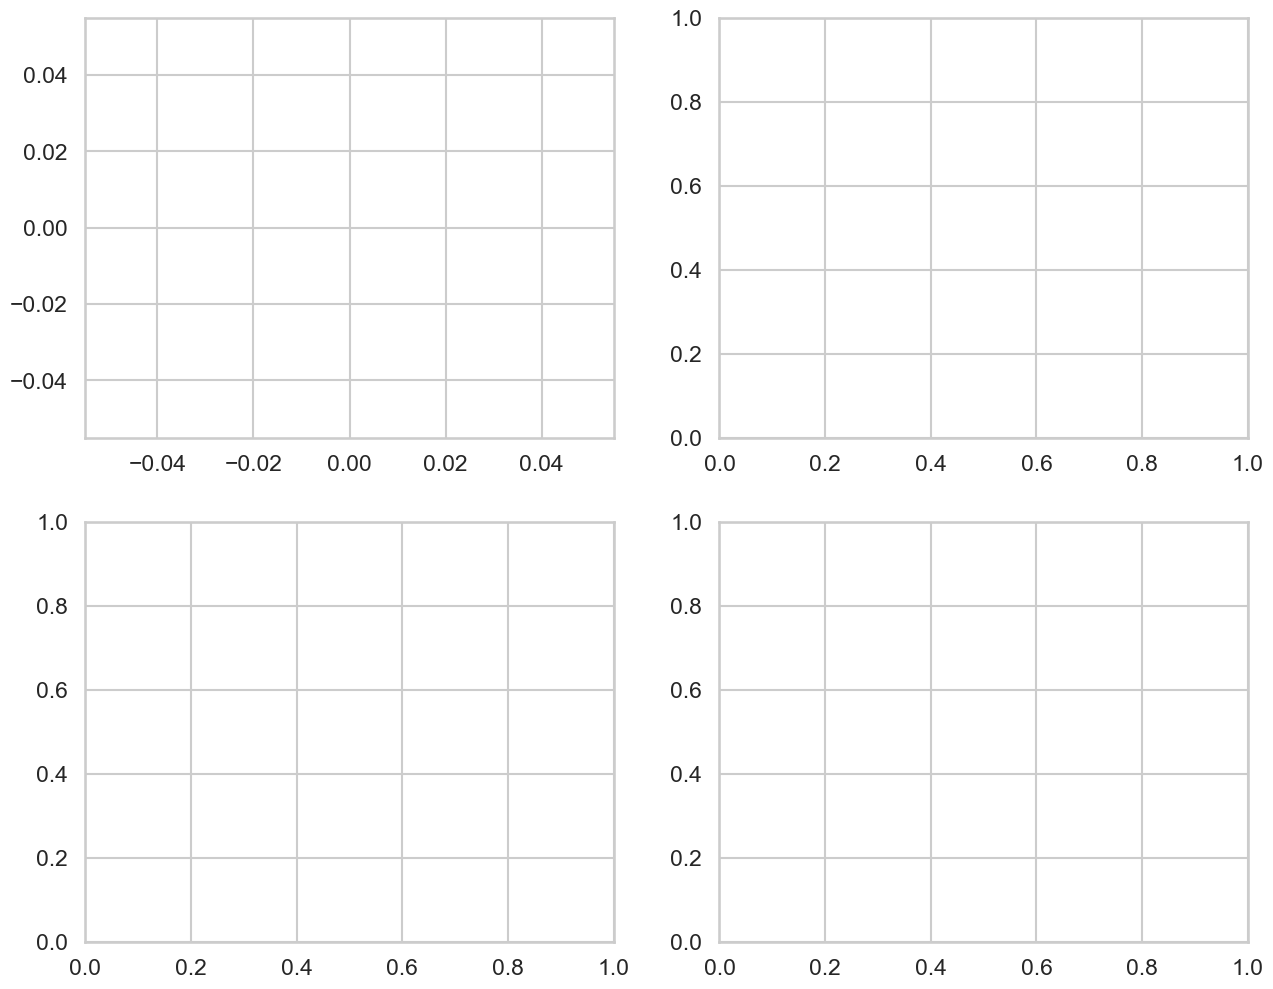

In [ ]:
# Préparation des données pour plotting
plot_data = df_rated.select(["rating", "is_weekend"]).to_pandas()
plot_data['period'] = plot_data['is_weekend'].map({True: 'Weekend', False: 'Semaine'})

# Création des subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Box plot
sns.boxplot(data=plot_data, x='period', y='rating', ax=axes[0,0])
axes[0,0].set_title('Distribution des ratings: Weekend vs Semaine')
axes[0,0].set_ylabel('Rating')

# 2. Violin plot
sns.violinplot(data=plot_data, x='period', y='rating', ax=axes[0,1])
axes[0,1].set_title('Densité des ratings: Weekend vs Semaine')
axes[0,1].set_ylabel('Rating')

# 3. Histogrammes superposés
axes[1,0].hist(weekday_ratings, bins=30, alpha=0.7, label='Semaine', color='blue', density=True)
axes[1,0].hist(weekend_ratings, bins=30, alpha=0.7, label='Weekend', color='red', density=True)
axes[1,0].set_title('Distribution des ratings (densité)')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Densité')
axes[1,0].legend()

# 4. Barplot des moyennes avec erreurs
means = [np.mean(weekday_ratings), np.mean(weekend_ratings)]
stds = [np.std(weekday_ratings), np.std(weekend_ratings)]
labels = ['Semaine', 'Weekend']
colors = ['blue', 'red']

bars = axes[1,1].bar(labels, means, yerr=stds, capsize=10, color=colors, alpha=0.7)
axes[1,1].set_title('Rating moyen ± écart-type')
axes[1,1].set_ylabel('Rating moyen')

# Ajout des valeurs sur les barres
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, mean + std + 0.01, 
                   f'{mean:.3f}\n±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 🕐 Analyse par jour de la semaine

📅 Statistiques par jour de la semaine:


,day_name,mean_rating,std_rating,n_ratings,is_weekend_day
0,Lundi,4.661441,0.717944,173178,False
1,Mardi,4.659778,0.720653,159014,False
2,Mercredi,4.660453,0.722655,149779,False
3,Jeudi,4.662665,0.721304,143697,False
4,Vendredi,4.660298,0.725251,131689,False
5,Samedi,4.663333,0.728259,139984,True
6,Dimanche,4.662497,0.726223,174179,True


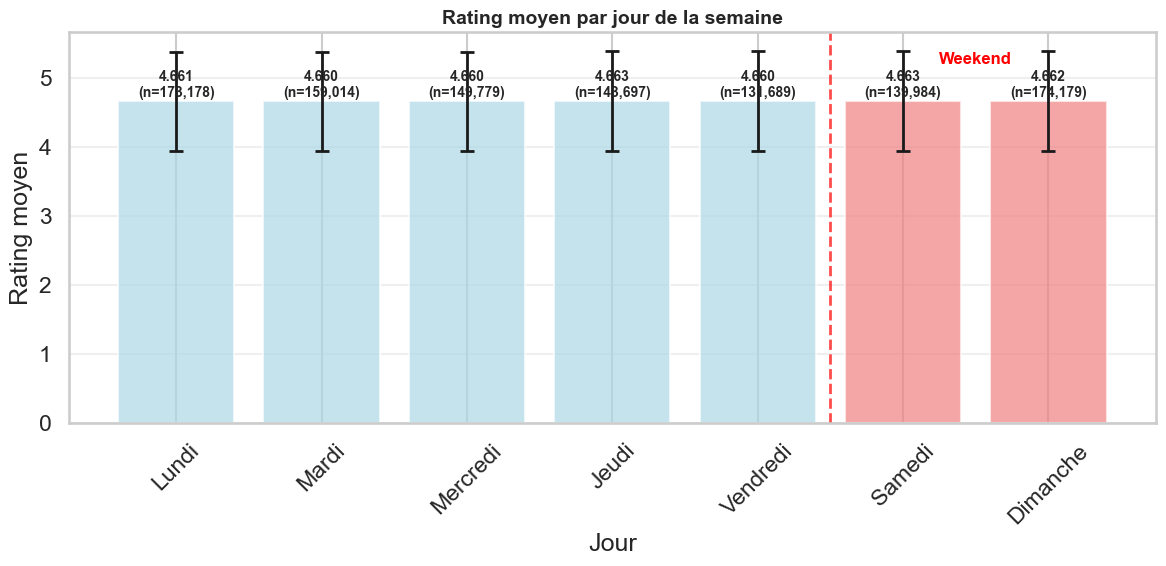

In [ ]:
# Ajout du jour de la semaine
df_with_weekday = df_rated.with_columns([
    pl.col("date").dt.weekday().alias("weekday")
])

# Statistiques par jour
weekday_stats = df_with_weekday.group_by("weekday").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_ratings")
]).sort("weekday")

weekday_pd = weekday_stats.to_pandas()

# Mapping des jours
day_names = {1: 'Lundi', 2: 'Mardi', 3: 'Mercredi', 4: 'Jeudi', 
             5: 'Vendredi', 6: 'Samedi', 7: 'Dimanche'}
weekday_pd['day_name'] = weekday_pd['weekday'].map(day_names)
weekday_pd['is_weekend_day'] = weekday_pd['weekday'].isin([6, 7])

print("📅 Statistiques par jour de la semaine:")
display(weekday_pd[['day_name', 'mean_rating', 'std_rating', 'n_ratings', 'is_weekend_day']])

# Graphique par jour avec Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

# Barres colorées selon weekend/semaine
colors = ['lightblue' if not is_weekend else 'lightcoral' 
          for is_weekend in weekday_pd['is_weekend_day']]

bars = ax.bar(weekday_pd['day_name'], weekday_pd['mean_rating'], 
              yerr=weekday_pd['std_rating'], 
              color=colors, alpha=0.7, 
              capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})

# Ajout des valeurs sur les barres
for bar, mean_val, n_val in zip(bars, weekday_pd['mean_rating'], weekday_pd['n_ratings']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{mean_val:.3f}\n(n={n_val:,})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('Rating moyen par jour de la semaine', fontsize=14, fontweight='bold')
ax.set_xlabel('Jour')
ax.set_ylabel('Rating moyen')
ax.grid(True, alpha=0.3, axis='y')

# Ajout d'une ligne de séparation weekend
ax.axvline(x=4.5, linestyle="--", color="red", alpha=0.7, linewidth=2)
ax.text(5.5, ax.get_ylim()[1] * 0.95, "Weekend", ha='center', va='top', 
        color='red', fontweight='bold', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🎯 Test ANOVA par jour de semaine

In [ ]:
# Test ANOVA pour différences entre jours
day_groups = []
for day in range(1, 8):
    ratings = df_with_weekday.filter(pl.col("weekday") == day).select("rating").to_series()
    if len(ratings) > 0:
        day_groups.append(ratings.to_pandas().tolist())

f_stat, p_value_anova = stats.f_oneway(*day_groups)

print(f"📊 Test ANOVA (7 jours de la semaine):")
print(f"   F-statistique: {f_stat:.4f}")
print(f"   p-value: {p_value_anova:.4f}")
print(f"   Degrés de liberté: {len(day_groups) - 1}")

if p_value_anova < 0.05:
    print(f"   ✅ Différences significatives entre jours")
    
    # Post-hoc: identifier les jours les plus différents
    print(f"\n🔍 Comparaisons post-hoc (top 5 différences):")
    
    pairwise_results = []
    for i in range(len(day_groups)):
        for j in range(i+1, len(day_groups)):
            day1, day2 = i+1, j+1
            _, p_pair = stats.mannwhitneyu(day_groups[i], day_groups[j], alternative='two-sided')
            mean_diff = abs(np.mean(day_groups[i]) - np.mean(day_groups[j]))
            pairwise_results.append((day1, day2, mean_diff, p_pair))
    
    # Tri par différence de moyenne (décroissant)
    pairwise_results.sort(key=lambda x: x[2], reverse=True)
    
    for day1, day2, mean_diff, p_pair in pairwise_results[:5]:
        p_corrected = p_pair * 21  # Correction de Bonferroni (7*6/2 = 21 comparaisons)
        significance = "***" if p_corrected < 0.001 else "**" if p_corrected < 0.01 else "*" if p_corrected < 0.05 else "ns"
        print(f"   {day_names[day1]} vs {day_names[day2]}: Δ={mean_diff:.4f} (p={p_corrected:.4f}) {significance}")
        
else:
    print(f"   ❌ Pas de différence significative entre jours")

# Test spécifique weekend vs jours de semaine
print(f"\n📅 Tests spécifiques weekend:")

# Samedi vs autres jours
saturday_ratings = day_groups[5]  # Samedi = index 5 (jour 6)
all_weekdays = []
for i in range(5):  # Lundi à Vendredi
    all_weekdays.extend(day_groups[i])

_, p_sat_weekdays = stats.mannwhitneyu(saturday_ratings, all_weekdays, alternative='two-sided')
print(f"   Samedi vs Semaine: p={p_sat_weekdays:.4f}")

# Dimanche vs autres jours
sunday_ratings = day_groups[6]  # Dimanche = index 6 (jour 7)
_, p_sun_weekdays = stats.mannwhitneyu(sunday_ratings, all_weekdays, alternative='two-sided')
print(f"   Dimanche vs Semaine: p={p_sun_weekdays:.4f}")

📊 Test ANOVA (7 jours de la semaine):
   F-statistique: 0.5307
   p-value: 0.7854
   Degrés de liberté: 6
   ❌ Pas de différence significative entre jours

📅 Tests spécifiques weekend:
   Samedi vs Semaine: p=0.0005
   Dimanche vs Semaine: p=0.0082


## 🔄 Analyse temporelle des patterns weekend

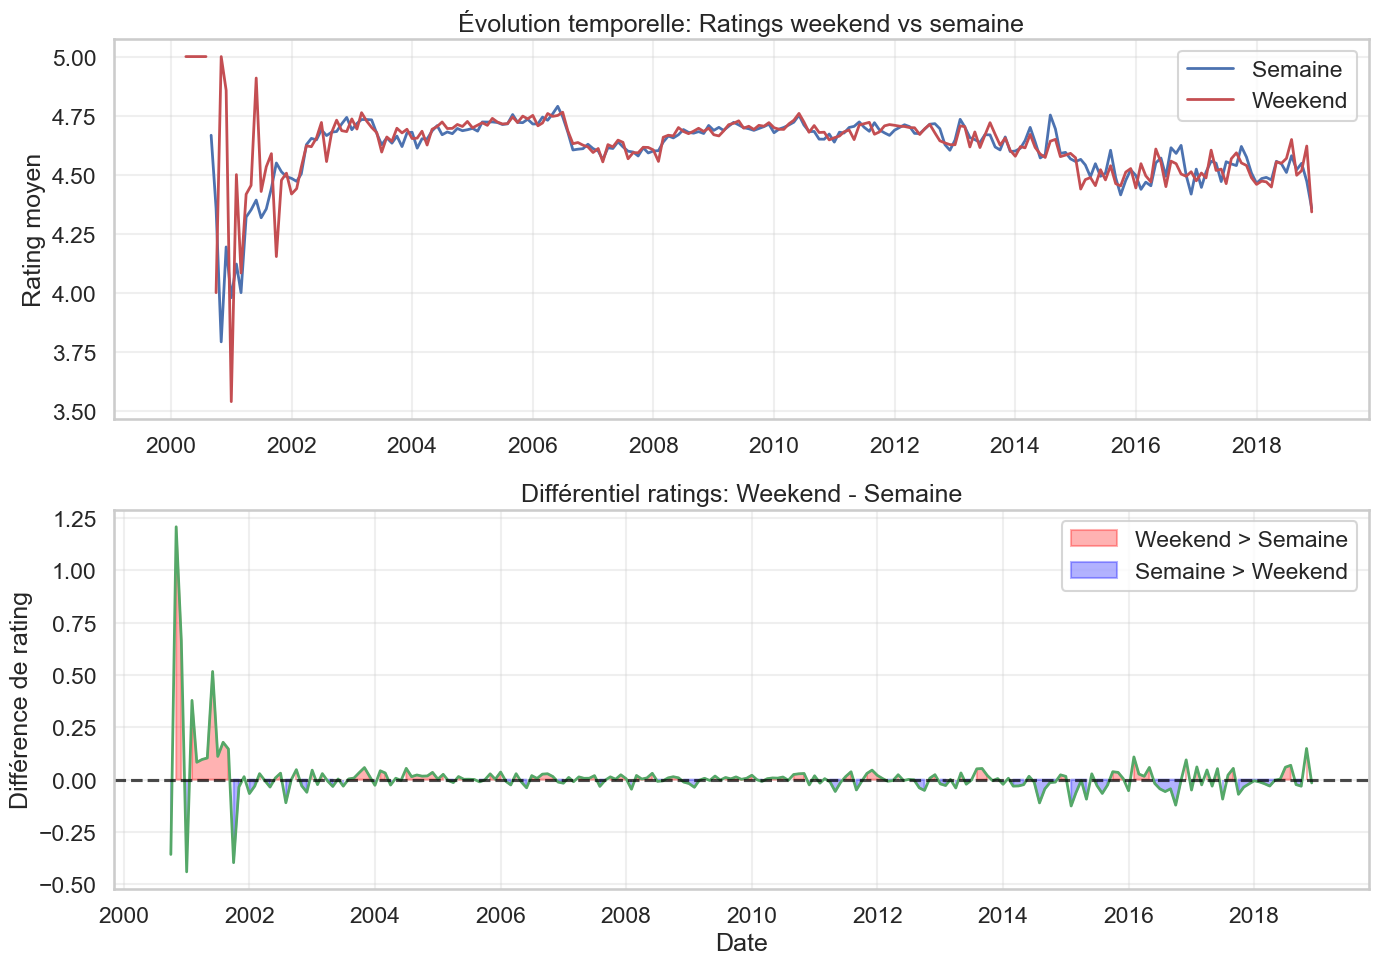

📊 Analyse du différentiel weekend-semaine:
   Moyenne: 0.0097
   Médiane: 0.0024
   Écart-type: 0.1198
   Min: -0.4403
   Max: 1.2083

📈 118/219 mois (53.9%) avec ratings weekend > semaine


In [ ]:
# Évolution du pattern weekend dans le temps
monthly_weekend = df_enriched.filter(pl.col("rating") > 0).group_by(["year", "month", "is_weekend"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.len().alias("n_ratings")
]).to_pandas()

# Pivot pour avoir weekend/semaine en colonnes
weekend_evolution = monthly_weekend.pivot_table(
    index=['year', 'month'], 
    columns='is_weekend', 
    values='mean_rating', 
    fill_value=np.nan
).reset_index()

weekend_evolution.columns = ['year', 'month', 'semaine', 'weekend']
weekend_evolution['date'] = pd.to_datetime(weekend_evolution[['year', 'month']].assign(day=1))
weekend_evolution['diff_weekend_semaine'] = weekend_evolution['weekend'] - weekend_evolution['semaine']

# Graphique de l'évolution temporelle
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Évolution des ratings weekend vs semaine
ax1.plot(weekend_evolution['date'], weekend_evolution['semaine'], 'b-', label='Semaine', linewidth=2)
ax1.plot(weekend_evolution['date'], weekend_evolution['weekend'], 'r-', label='Weekend', linewidth=2)
ax1.set_title('Évolution temporelle: Ratings weekend vs semaine')
ax1.set_ylabel('Rating moyen')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Différentiel weekend - semaine
ax2.plot(weekend_evolution['date'], weekend_evolution['diff_weekend_semaine'], 'g-', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.fill_between(weekend_evolution['date'], weekend_evolution['diff_weekend_semaine'], 0, 
                 where=(weekend_evolution['diff_weekend_semaine'] > 0), color='red', alpha=0.3, label='Weekend > Semaine')
ax2.fill_between(weekend_evolution['date'], weekend_evolution['diff_weekend_semaine'], 0, 
                 where=(weekend_evolution['diff_weekend_semaine'] < 0), color='blue', alpha=0.3, label='Semaine > Weekend')
ax2.set_title('Différentiel ratings: Weekend - Semaine')
ax2.set_xlabel('Date')
ax2.set_ylabel('Différence de rating')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques du différentiel
valid_diffs = weekend_evolution['diff_weekend_semaine'].dropna()
print(f"📊 Analyse du différentiel weekend-semaine:")
print(f"   Moyenne: {valid_diffs.mean():.4f}")
print(f"   Médiane: {valid_diffs.median():.4f}")
print(f"   Écart-type: {valid_diffs.std():.4f}")
print(f"   Min: {valid_diffs.min():.4f}")
print(f"   Max: {valid_diffs.max():.4f}")

positive_months = (valid_diffs > 0).sum()
total_months = len(valid_diffs)
print(f"\n📈 {positive_months}/{total_months} mois ({positive_months/total_months*100:.1f}%) avec ratings weekend > semaine")